Anchor setting only for person class

model load

In [2]:
# Copied from `train` function in train_simple.py:L78
import yaml

device = 'cpu'
hyp = 'data/hyps/for_anchor/hyp.scratch-anchor.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5n_kaist-rgbt.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]
Overriding model.yaml nc=1 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.MultiStreamConv           [3, 16, 6, 2, 2]              
  1                -1  1      9344  models.common.MultiStreamConv           [16, 32, 3, 2]                
  2                -1  1      9600  models.common.MultiStreamC3             [32, 32, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1      4224  models.common.Conv                      [64, 64, 1, 1]                
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 2]                
  6                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  7                -1  1     73984  models.common.Conv 

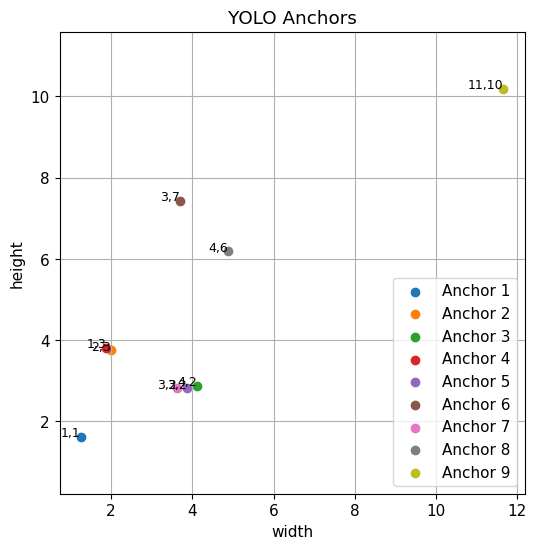

In [3]:
# code
# 반드시 첫 셀 또는 해당 셀 상단에 추가
%matplotlib inline  

import matplotlib.pyplot as plt
import numpy as np
import torch

# anchors: Tensor (3, 3, 2) 형태일 것임 (layer 수, anchor 수, [w, h])
anchors = model.model[-1].anchors  # shape: torch.Size([3, 3, 2])

# Tensor → numpy 변환 (detach, cpu, numpy)
all_anchors = anchors.clone().detach().cpu().numpy().reshape(-1, 2)

# 시각화
plt.close('all')
plt.figure(figsize=(6, 6))
plt.title("YOLO Anchors")
plt.xlabel("width")
plt.ylabel("height")
plt.grid(True)

for i, (w, h) in enumerate(all_anchors):
    plt.scatter(w, h, label=f"Anchor {i+1}")
    plt.text(w, h, f"{int(w)},{int(h)}", fontsize=9, ha='right')

plt.legend()
plt.axis("equal")
plt.show()

GT vs label
분포 비교

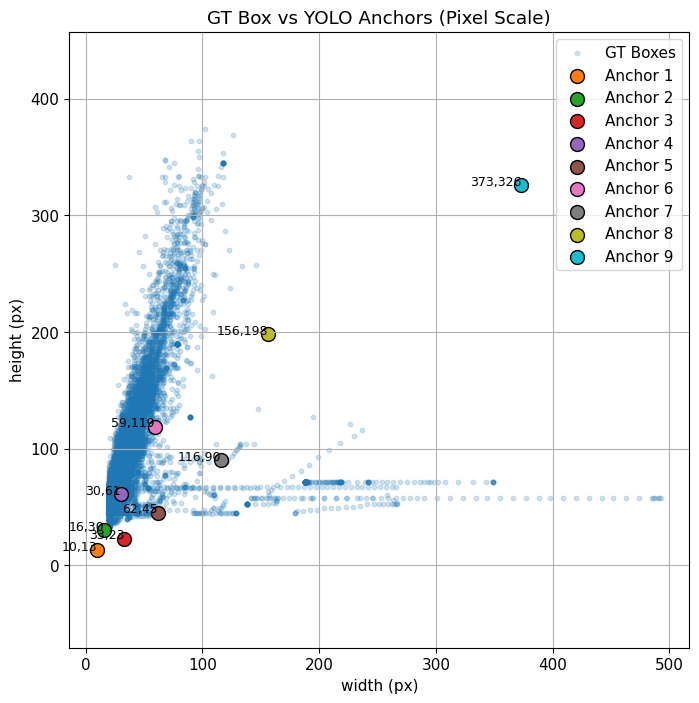

In [4]:
# 기존 anchor랑 GT 분포 비교
# Jupyter용 설정
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import glob
import os

# 1. Anchor 가져오기
anchors = model.model[-1].anchors  # shape: (3, 3, 2)
all_anchors = anchors.clone().detach().cpu().numpy().reshape(-1, 2)

# 2. stride 기준으로 pixel 단위 스케일 변환
strides = [8, 16, 32]
scaled_anchors = all_anchors.copy()
scaled_anchors[:3] *= strides[0]
scaled_anchors[3:6] *= strides[1]
scaled_anchors[6:9] *= strides[2]

# 3. GT label(.txt) 경로 설정
label_dir = 'datasets/kaist-rgbt/train/labels'  # ← 경로 수정 필요 시 변경
label_paths = glob.glob(os.path.join(label_dir, '*.txt'))

gt_widths = []
gt_heights = []

for path in label_paths:
    with open(path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) >= 6:
                ignore = int(parts[5])
                if ignore != 0:
                    continue  # ignore=1이면 건너뜀
                w = float(parts[3])
                h = float(parts[4])
                gt_widths.append(w)
                gt_heights.append(h)

# 4. GT 박스를 pixel 단위로 복원
img_size = 640  # input size
gt_widths_pixel = np.array(gt_widths) * img_size
gt_heights_pixel = np.array(gt_heights) * img_size

# 5. 시각화
plt.figure(figsize=(8, 8))
plt.scatter(gt_widths_pixel, gt_heights_pixel, alpha=0.2, s=10, label='GT Boxes')

for i, (w, h) in enumerate(scaled_anchors):
    plt.scatter(w, h, s=100, edgecolors='black', label=f"Anchor {i+1}")
    plt.text(w, h, f"{int(w)},{int(h)}", fontsize=9, ha='right')

plt.xlabel("width (px)")
plt.ylabel("height (px)")
plt.title("GT Box vs YOLO Anchors (Pixel Scale)")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.show()

IoU distance 기반 Clustering
Cluster별 개수 동일하지 않음

📌 Anchors (pixels):
[[45, 140], [61, 181], [22, 58], [23, 71], [32, 68], [20, 45], [30, 91], [39, 107], [83, 266]]


/tmp/ipykernel_30690/193852862.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', k)


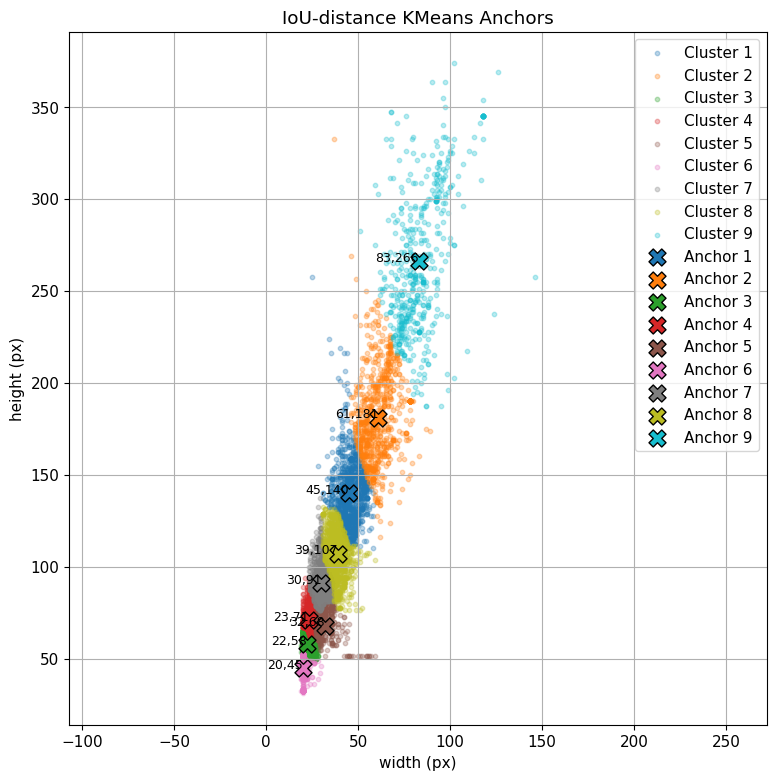

,Anchor ID,GT Count,Mean Width,Mean Height,Std Width,Std Height
0,1,1223,45.0,140.4,5.1,15.1
1,2,820,60.8,180.7,8.0,23.9
2,3,1184,21.6,58.4,2.0,3.9
3,4,1386,23.2,71.1,1.8,5.1
4,5,546,31.7,68.2,4.8,6.8
5,6,419,20.4,44.8,1.3,5.8
6,7,1007,29.9,91.1,2.8,9.3
7,8,1280,38.7,106.9,3.9,11.6
8,9,491,83.5,266.3,12.7,39.2


In [5]:
# IoU-distance K-means clustering (Jupyter 단일 셀 버전)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import glob
import os
from IPython.display import display

# ------------------------------
# 1. GT box 불러오기 (YOLO format 기준)
label_dir = 'datasets/kaist-rgbt/train/labels'  # ← 데이터 경로 수정 가능
img_size = 640

label_paths = glob.glob(os.path.join(label_dir, '*.txt'))
gt_boxes = []

for path in label_paths:
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            cls = int(parts[0])
            ignore = int(parts[5])
            if cls != 0 or ignore != 0:
                continue
            w, h = float(parts[3]), float(parts[4])
            gt_boxes.append([w * img_size, h * img_size])  # pixel 단위 변환

boxes = np.array(gt_boxes)
boxes = boxes[(boxes >= 2).all(axis=1)]  # 너무 작은 박스 제거

# ------------------------------
# 2. IoU distance 함수
def iou_distance(box, anchors):
    w, h = box
    aw, ah = anchors[:, 0], anchors[:, 1]
    inter = np.minimum(w, aw) * np.minimum(h, ah)
    union = w * h + aw * ah - inter
    iou = inter / (union + 1e-9)
    return 1 - iou

# ------------------------------
# 3. IoU-KMeans
def iou_kmeans(boxes, k=9, max_iter=20):
    indices = np.random.choice(len(boxes), k, replace=False)
    centers = boxes[indices]

    for _ in range(max_iter):
        distances = np.array([iou_distance(box, centers) for box in boxes])
        cluster_ids = np.argmin(distances, axis=1)

        new_centers = []
        for i in range(k):
            cluster = boxes[cluster_ids == i]
            if len(cluster) == 0:
                new_centers.append(centers[i])
            else:
                new_centers.append(np.mean(cluster, axis=0))
        centers = np.array(new_centers)

    return centers, cluster_ids

# ------------------------------
# 4. KMeans 수행 및 출력
k = 9
anchors, cluster_ids = iou_kmeans(boxes, k)

anchors_pixel = np.round(anchors).astype(int)
print("📌 Anchors (pixels):")
print(anchors_pixel.tolist())

# ------------------------------
# 5. 시각화 및 통계 출력
bins = [boxes[cluster_ids == i] for i in range(k)]
colors = cm.get_cmap('tab10', k)

plt.figure(figsize=(9, 9))
for i, b in enumerate(bins):
    plt.scatter(b[:, 0], b[:, 1], color=colors(i), alpha=0.3, s=10, label=f'Cluster {i+1}')
for i, (w, h) in enumerate(anchors_pixel):
    plt.scatter(w, h, s=150, edgecolors='black', color=colors(i), label=f"Anchor {i+1}", marker='X')
    plt.text(w, h, f"{w},{h}", fontsize=9, ha='right', color='black')

plt.xlabel("width (px)")
plt.ylabel("height (px)")
plt.title("IoU-distance KMeans Anchors")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.show()

# 통계 테이블
cluster_stats = []
for i, b in enumerate(bins):
    mean = np.mean(b, axis=0)
    std = np.std(b, axis=0)
    cluster_stats.append({
        "Anchor ID": i+1,
        "GT Count": len(b),
        "Mean Width": round(mean[0], 1),
        "Mean Height": round(mean[1], 1),
        "Std Width": round(std[0], 1),
        "Std Height": round(std[1], 1)
    })

df_stats = pd.DataFrame(cluster_stats)
display(df_stats)


Anchor 적합성 확인


In [9]:
import numpy as np
import torch
import glob
import os
import yaml

# -------------------------------
# 1. GT 라벨에서 width, height 수집
# -------------------------------
label_dir = 'datasets/kaist-rgbt/train/labels'  # ← 경로 수정 가능
img_size = 640
threshold = 4.0  # anchor_t와 동일 (즉, IoU > 1/threshold = 0.25 이상이면 매칭으로 판단)

label_paths = glob.glob(os.path.join(label_dir, '*.txt'))
wh_list = []

for path in label_paths:
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                w, h = float(parts[3]), float(parts[4])
                if w > 0 and h > 0:
                    wh_list.append([w * img_size, h * img_size])  # pixel 단위 변환

wh = torch.tensor(wh_list)  # shape: (N, 2)


# -------------------------------
# 2. YAML에서 anchor 불러오기
# -------------------------------
yaml_path = 'models/anchors/yolov5n_kaist-rgbt-anchor2.yaml'  # anchor yaml 경로
with open(yaml_path, 'r') as f:
    cfg = yaml.safe_load(f)

# anchors: List[List[float]] 형태 → torch.tensor로 변환
anchors_raw = cfg['anchors']  # 예: [[20,45, 22,58, 23,71], [32,68, 30,91, 39,107], [45,140, 61,181, 84,266]]
anchors = torch.tensor(anchors_raw, dtype=torch.float32).view(-1, 2)  # shape: (9, 2)

# -------------------------------
# 3. BPR 계산 (Best Possible Recall)
# -------------------------------
r = wh[:, None, :] / anchors[None, :, :]  # shape: (N, 9, 2)
x = torch.min(r, 1 / r).min(2)[0]         # ratio-based metric
best = x.max(1)[0]                        # best matching anchor IoU

bpr = (best > 1 / threshold).float().mean()  # recall = GT 중 anchor와 매칭된 비율
aat = (x > 1 / threshold).float().sum(1).float().mean()  # anchors per target

# -------------------------------
# 4. 출력
# -------------------------------
print(f"📐 Anchor Recall 분석 결과:")
print(f" - GT 개수: {len(wh)}")
print(f" - Anchors per target (AAT): {aat:.2f}")
print(f" - Best Possible Recall (BPR): {bpr:.4f}")

if bpr > 0.98:
    print("✅ Anchor가 GT와 잘 맞습니다.")
elif bpr > 0.90:
    print("⚠️ Anchor가 대부분 맞지만 일부 GT에 잘 맞지 않을 수 있습니다.")
else:
    print("❌ Anchor 재설계가 필요할 수 있습니다.")


📐 Anchor Recall 분석 결과:
 - GT 개수: 13312
 - Anchors per target (AAT): 7.54
 - Best Possible Recall (BPR): 1.0000
✅ Anchor가 GT와 잘 맞습니다.


IoU based k-means, cluster 개수 맞지 않음, w > h 데이터 필터링 안함


📌 Anchors (pixels):
[[25, 72], [56, 166], [21, 53], [38, 57], [43, 124], [216, 67], [83, 67], [80, 252], [34, 94]]


/tmp/ipykernel_30690/548166895.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', k)


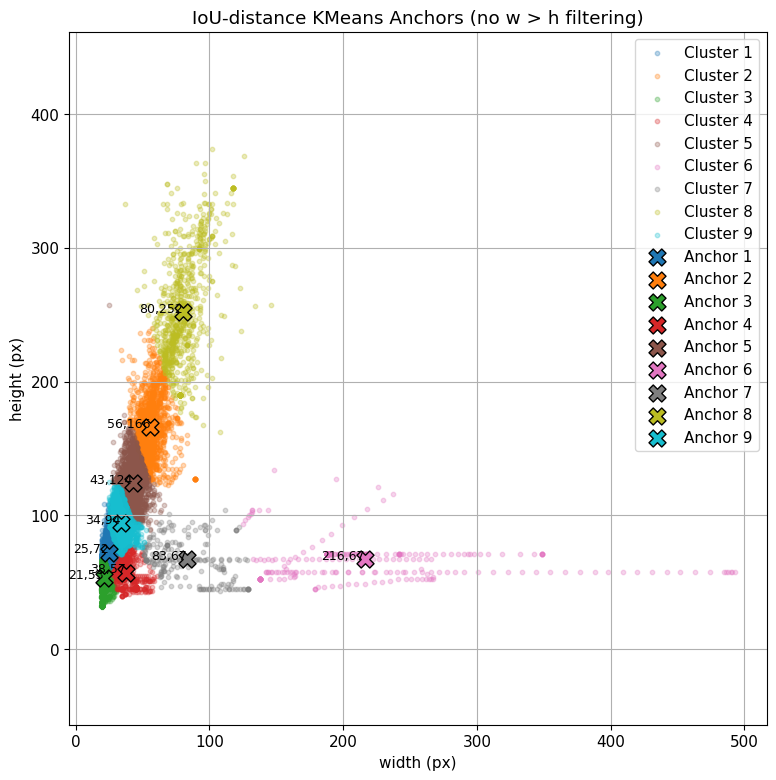

,Anchor ID,GT Count,Mean Width,Mean Height,Std Width,Std Height
0,1,2777,24.8,71.6,2.8,7.3
1,2,1478,56.0,165.9,7.6,21.7
2,3,2137,21.3,53.4,2.0,7.7
3,4,601,38.4,57.5,6.6,9.4
4,5,2566,42.6,124.2,4.9,14.3
5,6,340,215.5,67.2,71.0,12.4
6,7,231,82.8,67.0,23.2,14.4
7,8,797,80.5,252.1,13.0,42.1
8,9,2385,33.8,93.8,4.5,10.5


In [8]:
# IoU-distance K-means clustering (Jupyter 단일 셀 버전, w > h 필터링 제거)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import glob
import os
from IPython.display import display

# ------------------------------
# 1. GT box 불러오기 (YOLO format 기준)
label_dir = 'datasets/kaist-rgbt/train/labels'  # ← 데이터 경로 수정 가능
img_size = 640

label_paths = glob.glob(os.path.join(label_dir, '*.txt'))
gt_boxes = []

for path in label_paths:
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            cls = int(parts[0])
            ignore = int(parts[5])
            # if cls != 0 or ignore != 0:
            #     continue
            w, h = float(parts[3]), float(parts[4])
            gt_boxes.append([w * img_size, h * img_size])  # pixel 단위 변환

boxes = np.array(gt_boxes)
boxes = boxes[(boxes >= 2).all(axis=1)]  # 너무 작은 박스 제거

# ------------------------------
# 2. IoU distance 함수
def iou_distance(box, anchors):
    w, h = box
    aw, ah = anchors[:, 0], anchors[:, 1]
    inter = np.minimum(w, aw) * np.minimum(h, ah)
    union = w * h + aw * ah - inter
    iou = inter / (union + 1e-9)
    return 1 - iou

# ------------------------------
# 3. IoU-KMeans
def iou_kmeans(boxes, k=9, max_iter=20):
    indices = np.random.choice(len(boxes), k, replace=False)
    centers = boxes[indices]

    for _ in range(max_iter):
        distances = np.array([iou_distance(box, centers) for box in boxes])
        cluster_ids = np.argmin(distances, axis=1)

        new_centers = []
        for i in range(k):
            cluster = boxes[cluster_ids == i]
            if len(cluster) == 0:
                new_centers.append(centers[i])
            else:
                new_centers.append(np.mean(cluster, axis=0))
        centers = np.array(new_centers)

    return centers, cluster_ids

# ------------------------------
# 4. KMeans 수행 및 출력
k = 9
anchors, cluster_ids = iou_kmeans(boxes, k)

anchors_pixel = np.round(anchors).astype(int)
print("📌 Anchors (pixels):")
print(anchors_pixel.tolist())

# ------------------------------
# 5. 시각화 및 통계 출력
bins = [boxes[cluster_ids == i] for i in range(k)]
colors = cm.get_cmap('tab10', k)

plt.figure(figsize=(9, 9))
for i, b in enumerate(bins):
    plt.scatter(b[:, 0], b[:, 1], color=colors(i), alpha=0.3, s=10, label=f'Cluster {i+1}')
for i, (w, h) in enumerate(anchors_pixel):
    plt.scatter(w, h, s=150, edgecolors='black', color=colors(i), label=f"Anchor {i+1}", marker='X')
    plt.text(w, h, f"{w},{h}", fontsize=9, ha='right', color='black')

plt.xlabel("width (px)")
plt.ylabel("height (px)")
plt.title("IoU-distance KMeans Anchors (no w > h filtering)")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.show()

# 통계 테이블
cluster_stats = []
for i, b in enumerate(bins):
    mean = np.mean(b, axis=0)
    std = np.std(b, axis=0)
    cluster_stats.append({
        "Anchor ID": i+1,
        "GT Count": len(b),
        "Mean Width": round(mean[0], 1),
        "Mean Height": round(mean[1], 1),
        "Std Width": round(std[0], 1),
        "Std Height": round(std[1], 1)
    })

df_stats = pd.DataFrame(cluster_stats)
display(df_stats)
